In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import gc

from scipy import signal
import lightgbm as lgb
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [52]:
from sklearn.metrics import roc_auc_score

In [53]:
X_train = pd.read_csv('../input/X_train.csv')
y_train = pd.read_csv('../input/y_train.csv')
X_test  = pd.read_csv('../input/X_test.csv')

In [4]:
rotated_tr = pd.read_csv('./rotated_train.csv')
rotated_te = pd.read_csv('./rotated_test.csv')

In [5]:
rotated_tr.head()

,Unnamed: 0,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_X,euler_Y,euler_Z,rotated_acceleration_X,rotated_acceleration_Y,rotated_acceleration_Z
0,0,0_0,0,0,-0.758531,-0.634351,-0.10488,-0.10597,0.049000,0.007993,0.000349,-0.748570,2.103000,-9.753200,2.843273,-0.024668,1.396667,-3.051001,-0.494137,0.399795
1,1,0_1,0,1,-0.758532,-0.634342,-0.10490,-0.10600,-0.045981,0.001089,0.000993,-0.422014,1.924020,-9.651080,2.843201,-0.024662,1.396651,-2.960201,-0.525346,0.233054
2,2,0_2,0,2,-0.758528,-0.634348,-0.10492,-0.10597,-0.060919,-0.010782,-0.005251,-0.374697,1.824474,-9.373766,2.843222,-0.024728,1.396677,-2.867595,-0.789269,0.182175
3,3,0_3,0,3,-0.758516,-0.634357,-0.10495,-0.10597,-0.008044,-0.014070,-0.000219,-0.134236,1.606922,-9.590436,2.843183,-0.024769,1.396712,-2.883905,-0.552604,-0.075144
4,4,0_4,0,4,-0.758522,-0.634352,-0.10495,-0.10596,0.040927,-0.007411,0.010239,-0.246872,1.565515,-9.845605,2.843197,-0.024785,1.396698,-2.977078,-0.352939,-0.157436


In [6]:
targets = y_train['surface'].value_counts().index
print(targets)
print(y_train['surface'].value_counts())

Index(['concrete', 'soft_pvc', 'wood', 'tiled', 'fine_concrete',
       'hard_tiles_large_space', 'soft_tiles', 'carpet', 'hard_tiles'],
      dtype='object')
concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64


In [7]:
target_to_id = {}
id_to_target = {}

for target in targets:
    if target not in target_to_id:
        new_id = len(target_to_id)
        target_to_id[target] = new_id
        id_to_target[new_id] = target

In [8]:
y_id = []
for i in range(len(y_train)):
    y_id.append(target_to_id[y_train['surface'].values[i]])
y_id = np.asarray(y_id)

In [9]:
class_num = len(targets)

In [10]:
y_id_one = np.zeros((len(y_id), class_num))
for i in range(len(y_id)):
    y_id_one[i, y_id[i]] = 1 

In [11]:
def norm_quat(df):
    norm = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2 + df['orientation_W']**2)**0.5
    df['orientation_X'] /= norm
    df['orientation_Y'] /= norm
    df['orientation_Z'] /= norm
    df['orientation_W'] /= norm
    return df

In [12]:
import math

def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [13]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [ ]:
Y_maxmin = pd.DataFrame([X_train.groupby('group_id')['linear_acceleration_Y'].max(), X_train.groupby('group_id')['linear_acceleration_Y'].min()]).T
Y_maxmin.columns = ['la_Y_max', 'la_Y_min']

In [ ]:
gr_sr = pd.DataFrame()
for i in range(73):
    gr = pd.DataFrame({'group_id':[i], 'surface':[y_train[y_train['group_id']==i]['surface'].iloc[0]]})
    gr_sr = pd.concat([gr_sr, gr], axis=0)

In [ ]:
Y_maxmin.merge(gr_sr, how ='left', on='group_id')

In [14]:
X_train = norm_quat(X_train)
X_test = norm_quat(X_test)

In [15]:
def fe_step1 (df):
    """Quaternions to Euler Angles"""
    
    x = df['orientation_X'].values
    y = df['orientation_Y'].values
    z = df['orientation_Z'].values
    w = df['orientation_W'].values
    nx, ny, nz = np.zeros(len(x)), np.zeros(len(y)), np.zeros(len(z)),
    for i in tqdm(range(len(x))):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx[i] = xx
        ny[i] = yy
        nz[i] = zz
    
    df['euler_X'] = nx
    df['euler_Y'] = ny
    df['euler_Z'] = nz
    return df

In [ ]:
X_train = fe_step1(X_train)
X_test = fe_step1(X_test)

In [38]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [39]:
cols = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']

In [40]:
for col in cols:
    X_train['cos_'+col] = np.cos(X_train[col])
    X_test['cos_'+col] = np.cos(X_test[col])

In [16]:
def highpass_filter(df):
    n_samples = 128
    sample_duration = 0.01
    sample_rate = n_samples * (1 / sample_duration)

    nyquist = 0.5 * sample_rate
    norm_low_cutoff = 500 / nyquist

    sos = signal.butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, df)
    
    return filtered_sig

In [17]:
def lowpass_filter(data, r=0.3):
    f_data = np.zeros_like(data)
    f_data[0] = data[0]
    for i in range(1, len(data)):
        if i % 128 == 0:
            f_data[i] = data[i]
        else:
            f_data[i] = r * data[i] + (1-r) * f_data[i-1]
    return f_data

In [18]:
for data in [X_train, X_test]:
    data['linear_acceleration_X'] = lowpass_filter(data['linear_acceleration_X'])
    data['linear_acceleration_Y'] = lowpass_filter(data['linear_acceleration_Y'])
    data['linear_acceleration_Z'] = lowpass_filter(data['linear_acceleration_Z'])
    #data['angular_velocity_X'] = highpass_filter(data['angular_velocity_X'])
    #data['angular_velocity_Y'] = highpass_filter(data['angular_velocity_Y'])
    #data['angular_velocity_Z'] = highpass_filter(data['angular_velocity_Z'])

In [19]:
def lagged_feature(df, lag_list):
    
    cols = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
    
    for col in cols:
        for i in lag_list:
            df[col+'-'+str(i)] = 0
            df.loc[i: , col+'-'+str(i)] = df.loc[:len(df)-(i+1), col].values
            df[col+'-'+col+'-'+str(i)] = df[col] - df[col+'-'+str(i)]
            
            df = df.drop([col+'-'+str(i)], axis=1)
    return df

In [20]:
def num_integration(df):
    
    cols = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
    
    for col in cols:
        i = 1
        df[col+'-'+str(i)] = 0
        df.loc[i: , col+'-'+str(i)] = df.loc[:len(df)-(i+1), col].values
        df['tmp'+col] = 0.5 * (df[col] + df[col+'-'+str(i)])
        df['num_int_'+col] = 0
        for j in tqdm(range(0, len(df), 128)):
            df.loc[j:j+128, 'num_int_'+col] = np.cumsum(df.loc[j:j+128, 'tmp'+col])

        df = df.drop([col+'-'+str(i)], axis=1)
        df = df.drop(['tmp'+col], axis=1)
    return df

In [41]:
X_train['linear_acceleration_Z'] = X_train['linear_acceleration_Z'] + 9.80665
X_test['linear_acceleration_Z'] = X_test['linear_acceleration_Z'] + 9.80665

In [42]:
lag_list = [1, 2]
X_train = lagged_feature(X_train, lag_list)
X_test = lagged_feature(X_test, lag_list)

In [43]:
X_train = num_integration(X_train)
X_test = num_integration(X_test)

100%|██████████| 3816/3816 [00:04<00:00, 766.37it/s]


In [24]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,angular_velocity_X-angular_velocity_X-1,angular_velocity_X-angular_velocity_X-2,angular_velocity_Y-angular_velocity_Y-1,angular_velocity_Y-angular_velocity_Y-2,angular_velocity_Z-angular_velocity_Z-1,angular_velocity_Z-angular_velocity_Z-2,linear_acceleration_X-linear_acceleration_X-1,linear_acceleration_X-linear_acceleration_X-2,linear_acceleration_Y-linear_acceleration_Y-1,linear_acceleration_Y-linear_acceleration_Y-2,linear_acceleration_Z-linear_acceleration_Z-1,linear_acceleration_Z-linear_acceleration_Z-2,num_int_angular_velocity_X,num_int_angular_velocity_Y,num_int_angular_velocity_Z,num_int_linear_acceleration_X,num_int_linear_acceleration_Y,num_int_linear_acceleration_Z
0,0_0,0,0,-0.758531,-0.634351,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.748570,2.103000,0.053450,0.107650,0.107650,0.017561,0.017561,0.000767,0.000767,-0.748570,-0.748570,2.103000,2.103000,0.053450,0.053450,0.053825,0.008781,0.000384,-0.374285,1.051500,0.026725
1,0_1,0,1,-0.758532,-0.634342,-0.10490,-0.10600,0.067851,0.029939,0.003385,-0.422014,1.924020,0.155570,-0.039799,0.067851,0.012378,0.029939,0.002618,0.003385,0.326556,-0.422014,-0.178980,1.924020,0.102120,0.155570,0.141575,0.032531,0.002460,-0.959577,3.065010,0.131235
2,0_2,0,2,-0.758528,-0.634348,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.374697,1.824474,0.432884,-0.060576,-0.100375,-0.001005,0.011373,-0.009364,-0.006746,0.047317,0.373873,-0.099546,-0.278526,0.277314,0.379434,0.179138,0.061967,0.001164,-1.357932,4.939257,0.425462
3,0_3,0,3,-0.758516,-0.634357,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,-0.134236,1.606922,0.216214,-0.020328,-0.080904,-0.009486,-0.010491,-0.002995,-0.012359,0.240461,0.287778,-0.217552,-0.317098,-0.216670,0.060644,0.176249,0.086158,-0.006312,-1.612399,6.654955,0.750011
4,0_4,0,4,-0.758522,-0.634352,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.246872,1.565515,-0.038955,0.018188,-0.002140,-0.011796,-0.021282,0.014219,0.011224,-0.112636,0.127825,-0.041407,-0.258959,-0.255169,-0.471839,0.172290,0.099708,-0.008176,-1.802953,8.241173,0.838640


In [ ]:
i=0
plt.plot(X_train.iloc[128*i:128*(i+1), :]['linear_acceleration_Y'])

for i in tqdm(range(0, len(X_train), 128)):
    X_train = X_train.drop(index=[i+j for j in range(1)])

In [25]:
def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

In [ ]:
train = X_train.loc[:, 'orientation_X':'orientation_W']
test = X_test.loc[:, 'orientation_X':'orientation_W']

train.columns = ['X','Y','Z','W']
test.columns = ['X','Y','Z','W']

for i in range(4):
    for j in range(i+1, 4):
        train[train.columns[i]+'-'+train.columns[j]] = train.iloc[:, i] - train.iloc[:, j]
        test[test.columns[i]+'-'+test.columns[j]] = test.iloc[:, i] - test.iloc[:, j]
        
train = pd.concat([train, X_train.loc[:, 'euler_X':'euler_Z']], axis=1)
test = pd.concat([test, X_test.loc[:, 'euler_X':'euler_Z']], axis=1)

In [ ]:
for data in [train, test]:
    data['euler_X-Y'] = data['euler_X']-data['euler_Y']
    data['euler_X-Z'] = data['euler_X']-data['euler_Z']
    data['euler_Y-Z'] = data['euler_Y']-data['euler_Z']
    
train = pd.concat([X_train['series_id'], train], axis=1)
test = pd.concat([X_test['series_id'], test], axis=1)

In [ ]:
train.head()

In [ ]:
X_train.head()

In [ ]:
def rotation_matrix(q0, q1, q2, q3):
    r00 = q0**2 - q1**2 - q2**2 + q3**2
    r01 = 2 * (q0*q3 + q1*q2)
    r02 = 2 * (q1*q3 - q0*q2)
    r10 = 2 * (q1*q2 - q0*q3)
    r11 = q0**2 - q1**2 + q2**2 - q3**2
    r12 = 2 * (q2*q3 + q0*q1)
    r20 = 2 * (q0*q2 + q1*q3)
    r21 = 2 * (-q0*q1 + q2*q3)
    r22 = q0**2 - q1**2 - q2**2 + q3**2
    R = np.array([[r00, r01, r02],[r10, r11, r12],[r20, r21, r22]])
    return R

In [ ]:
def rotated_acceleration(df):
    
    df['rotated_acceleration_X'] = 0
    df['rotated_acceleration_Y'] = 0
    df['rotated_acceleration_Z'] = 0
    #df['rotated_angvel_X'] = 0
    #df['rotated_angvel_Y'] = 0
    #df['rotated_angvel_Z'] = 0
    
    q0_all = df['orientation_X'].values
    q1_all = df['orientation_Y'].values
    q2_all = df['orientation_Z'].values
    q3_all = df['orientation_W'].values
    la_X = df['linear_acceleration_X'].values
    la_Y = df['linear_acceleration_Y'].values
    la_Z = df['linear_acceleration_Z'].values
    #av_X = df['angular_velocity_X'].values
    #av_Y = df['angular_velocity_Y'].values
    #av_Z = df['angular_velocity_Z'].values
    
    for i in tqdm(range(len(df))):
        q0 = q0_all[i]
        q1 = q1_all[i]
        q2 = q2_all[i]
        q3 = q3_all[i]
        
        R = rotation_matrix(q0, q1, q2, q3)
        la = np.array([la_X[i], la_Y[i], la_Z[i]])
        #av = np.array([av_X[i], av_Y[i], av_Z[i]])
        rotated_la = np.dot(R.T, la)
        #rotated_av = np.dot(R.T, av)
        
        df.loc[i, 'rotated_acceleration_X'] = rotated_la[0]
        df.loc[i, 'rotated_acceleration_Y'] = rotated_la[1]
        df.loc[i, 'rotated_acceleration_Z'] = rotated_la[2]
        #df.loc[i, 'rotated_angvel_X'] = rotated_av[0]
        #df.loc[i, 'rotated_angvel_Y'] = rotated_av[1]
        #df.loc[i, 'rotated_angvel_Z'] = rotated_av[2]
    
    return df

In [ ]:
X_train = rotated_acceleration(X_train)

In [ ]:
X_test = rotated_acceleration(X_test)

In [ ]:
X_train['rotated_acceleration_Y'] = X_train['rotated_acceleration_Y'] - 9.80665
X_test['rotated_acceleration_Y'] = X_test['rotated_acceleration_Y'] - 9.80665

from multiprocessing import Pool

def process_subtrain(arg_tuple):
    start, end, idx = arg_tuple
    X_tr = X_train.iloc[start:end, :]
    X_tr = rotated_acceleration(X_tr)
    return idx, X_tr

all_chunks = []

num_cores = 8 
total_size = len(X_train)
chunk_size = total_size/num_cores

for i in range(8):
    start_idx = int(i * chunk_size)
    end_idx = int(start_idx + chunk_size)
    chunk = (start_idx, end_idx, i)
    all_chunks.append(chunk)

pool = Pool()
results = pool.map(process_subtrain, all_chunks)    
results = sorted(results, key=lambda tup: tup[0])


X = np.concatenate([item[1] for item in results], axis=0)

train = pd.concat([train, X_train.loc[:, 'rotated_acceleration_X':'rotated_acceleration_Z']], axis=1)
test = pd.concat([test, X_test.loc[:, 'rotated_acceleration_X':'rotated_acceleration_Z']], axis=1)

In [ ]:
def feat_eng(df):
    data = pd.DataFrame()
    df['total_rotated_acce'] = (df['rotated_acceleration_X']**2 + df['rotated_acceleration_Y']**2 + df['rotated_acceleration_Z']**2)**0.5
    df['ang_XY'] = np.arctan2(df['X'], df['Y'])
    df['ang_ZW'] = np.arctan2(df['Z'], df['W'])
    
    df_columns = df.columns[1:]
    for col in tqdm(df_columns):
        data[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        #data[col + '_median'] = df.groupby(['series_id'])[col].median()
        data[col + '_max'] = df.groupby(['series_id'])[col].max()
        data[col + '_min'] = df.groupby(['series_id'])[col].min()
        data[col + '_std'] = df.groupby(['series_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        
        data[col + '_mean_abs_chg'] = df.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        data[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [ ]:
train = pd.concat([train, rotated_tr.loc[:, 'rotated_acceleration_X':'rotated_acceleration_Z']], axis=1)
test = pd.concat([test, rotated_te.loc[:, 'rotated_acceleration_X':'rotated_acceleration_Z']], axis=1)

In [ ]:
train = feat_eng(train)
test = feat_eng(test)

In [ ]:
data_col = train.columns

In [ ]:
train.head()

In [ ]:
for data in [train, test]:
    data.fillna(0,inplace=True)
    data.replace(-np.inf,0,inplace=True)
    data.replace(np.inf,0,inplace=True)

In [ ]:
y_gr = y_train['group_id']

In [ ]:
N_SPLITS=4

splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(train, y_gr))

clf = []
val_acc = []
val_pred = []
val_y = []

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'multi_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'multiclass',
               'num_class': 73,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }

for train_idx, val_idx in splits:
    X_tr, y_tr = np.asarray(train)[train_idx, :], y_gr[train_idx]
    X_val, y_val = np.asarray(train)[val_idx, :], y_gr[val_idx]
    
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)
    val_pred.append(pred_lgb)
    val_y.append(y_val)
    
    val_acc.append(accuracy_score(y_val, np.argmax(pred_lgb, axis=1)))

#pred_lgb = pd.DataFrame(pred_lgb, index=np.where(np.mean(adv_val, axis=0)>0.3))
#val_pred = pd.concat([val_pred, pred_lgb], axis=0)

    clf.append(model_lgb)

In [ ]:
val_acc

In [ ]:
feature_imp = np.zeros(train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/4, index=data_col).sort_values(by=0, ascending=False)

In [ ]:
X_train_reserve = X_train.copy()
X_test_reserve = X_test.copy()

In [ ]:
X_train_reserve.to_csv('./rotated_train.csv')
X_test_reserve.to_csv('./rotated_test.csv')

In [54]:
def feat_eng(df):
    data = pd.DataFrame()

    df['total_acce'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
    #df['total_rotated'] = (df['rotated_acceleration_X']**2 + df['rotated_acceleration_Y']**2 + df['rotated_acceleration_Z']**2)**0.5
    #df['total_ang_cos'] = (df['cos_angular_velocity_X']**2 + df['cos_angular_velocity_Y']**2 + df['cos_angular_velocity_Z']**2)**0.5
    
    #df = df.drop(columns=['euler_X'], axis=0)
    #df = df.drop(columns=['euler_Y'], axis=0)
    #df = df.drop(columns=['euler_Z'], axis=0)
    #df['total_angu'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z']**2)**0.5
    
    #df['total_eule'] = (df['euler_X']**2 + df['euler_Y']**2 + df['euler_Z']**2)**0.5
    #df['total_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2)**0.5
    #df['total_acc/vel'] = df['total_acce']/df['total_angu']
    
    df_columns = df.columns[7:]
    for col in tqdm(df_columns):
        data[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        data[col + '_median'] = df.groupby(['series_id'])[col].median()
        data[col + '_max'] = df.groupby(['series_id'])[col].max()
        data[col + '_min'] = df.groupby(['series_id'])[col].min()
        data[col + '_std'] = df.groupby(['series_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        data[col + '_mean_abs_chg'] = df.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        data[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [55]:
X_train = feat_eng(X_train)
X_test = feat_eng(X_test)

100%|██████████| 7/7 [00:14<00:00,  2.13s/it]


In [ ]:
y = np.concatenate((np.zeros(len(X_train)), np.ones(len(X_test))), axis=0)
X = np.concatenate((X_train, X_test), axis=0)

In [29]:
N_SPLITS=4

In [ ]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))

clf_2 = []
val_roc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'binary_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary',
               #'num_class': class_num,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in splits:
    X_tr, y_tr = X[train_idx, :], y[train_idx]
    X_val, y_val = X[val_idx, :], y[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)
    
    val_roc.append(roc_auc_score(y_val, (pred_lgb>0.5).astype(int)))
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=0)
    
    clf_2.append(model_lgb)

In [ ]:
val_roc

In [ ]:
feature_imp = np.zeros(X.shape[1])
for model in clf_2:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=X_train.columns).sort_values(by=0, ascending=False)

In [56]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_train, y_id))

clf_3 = []
val_acc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.9,
               'metric': 'multi_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'multiclass',
               'num_class': class_num,
               'num_leaves': 2**5,
               'verbose':0, 
               'seed':123
              }

for train_idx, val_idx in splits:
    X_tr, y_tr = X_train.iloc[train_idx, :], y_id[train_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_id[val_idx]
    
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)

    val_acc.append(accuracy_score(y_val, np.argmax(pred_lgb, axis=1)))

#pred_lgb = pd.DataFrame(pred_lgb, index=np.where(np.mean(adv_val, axis=0)>0.3))
#val_pred = pd.concat([val_pred, pred_lgb], axis=0)

clf_3.append(model_lgb)

[1]	valid_0's multi_logloss: 1.89035
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.79483
[3]	valid_0's multi_logloss: 1.72488
[4]	valid_0's multi_logloss: 1.66514
[5]	valid_0's multi_logloss: 1.61486
[6]	valid_0's multi_logloss: 1.56921
[7]	valid_0's multi_logloss: 1.52869
[8]	valid_0's multi_logloss: 1.49418
[9]	valid_0's multi_logloss: 1.46398
[10]	valid_0's multi_logloss: 1.43555
[11]	valid_0's multi_logloss: 1.41064
[12]	valid_0's multi_logloss: 1.38991
[13]	valid_0's multi_logloss: 1.36884
[14]	valid_0's multi_logloss: 1.35254
[15]	valid_0's multi_logloss: 1.33655
[16]	valid_0's multi_logloss: 1.32108
[17]	valid_0's multi_logloss: 1.30668
[18]	valid_0's multi_logloss: 1.29276
[19]	valid_0's multi_logloss: 1.28239
[20]	valid_0's multi_logloss: 1.2724
[21]	valid_0's multi_logloss: 1.26148
[22]	valid_0's multi_logloss: 1.25181
[23]	valid_0's multi_logloss: 1.24176
[24]	valid_0's multi_logloss: 1.23507
[25]	valid_0's multi_logloss: 1.2277

[48]	valid_0's multi_logloss: 1.20612
[49]	valid_0's multi_logloss: 1.20673
[50]	valid_0's multi_logloss: 1.20696
[51]	valid_0's multi_logloss: 1.20646
[52]	valid_0's multi_logloss: 1.20557
[53]	valid_0's multi_logloss: 1.20683
[54]	valid_0's multi_logloss: 1.20749
[55]	valid_0's multi_logloss: 1.20854
[56]	valid_0's multi_logloss: 1.20904
[57]	valid_0's multi_logloss: 1.21098
[58]	valid_0's multi_logloss: 1.21291
[59]	valid_0's multi_logloss: 1.21467
[60]	valid_0's multi_logloss: 1.21518
[61]	valid_0's multi_logloss: 1.21627
[62]	valid_0's multi_logloss: 1.21795
[63]	valid_0's multi_logloss: 1.2191
[64]	valid_0's multi_logloss: 1.22068
[65]	valid_0's multi_logloss: 1.22
[66]	valid_0's multi_logloss: 1.22212
[67]	valid_0's multi_logloss: 1.22405
[68]	valid_0's multi_logloss: 1.22612
[69]	valid_0's multi_logloss: 1.23075
[70]	valid_0's multi_logloss: 1.2323
[71]	valid_0's multi_logloss: 1.23384
[72]	valid_0's multi_logloss: 1.2338
[73]	valid_0's multi_logloss: 1.23671
Early stopping, be

In [57]:
val_acc

[0.5878661087866108,
 0.5918153200419727,
 0.5756302521008403,
 0.6016859852476291]

In [58]:
np.mean(val_acc)

0.5892494165442632

In [ ]:
val_acc

In [ ]:
np.mean(val_acc)

In [59]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf_3:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=X_train.columns).sort_values(by=0, ascending=False)

,0
linear_acceleration_Y_mean_abs_chg,4009.472764
linear_acceleration_X_mean_abs_chg,3494.011947
angular_velocity_Y_mean_abs_chg,2932.809331
total_acce_mean,1941.469555
angular_velocity_Z_min,1848.277313
linear_acceleration_Z_mean_abs_chg,1505.566458
linear_acceleration_Y_std,1257.063146
angular_velocity_Y_maxtoMin,1191.801301
total_acce_std,1125.272661
total_acce_mean_abs_chg,1073.595474


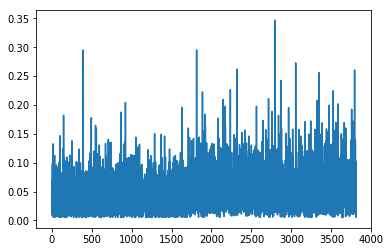

In [50]:
plt.plot(X_train['angular_velocity_Y-angular_velocity_Y-1_mean_abs_chg'])

In [ ]:
test_pred = []
for model in clf:
    pred_test = model.predict(test)
    test_pred.append(pred_test)

In [ ]:
test_pred = (test_pred[0]+test_pred[1]+test_pred[2]+test_pred[3])/4

In [ ]:
test_pr = pd.concat([pd.Series(np.argmax(test_pred, axis=1)), pd.Series(np.max(test_pred, axis=1))], axis=1)
test_pr.columns = ['group_id', 'prob']

In [ ]:
test_pr

In [ ]:
gr_sr = pd.DataFrame()
for i in range(73):
    gr = pd.DataFrame({'group_id':[i], 'surface':[y_train[y_train['group_id']==i]['surface'].iloc[0]]})
    gr_sr = pd.concat([gr_sr, gr], axis=0)

In [ ]:
test_pr = test_pr.merge(gr_sr, how='left', on='group_id', sort=False)

In [ ]:
test_gr_idx = test_pr[test_pr['prob']<=0.9].index

In [ ]:
X_test.loc[test_gr_idx, :].head()

In [ ]:
preds_test = []

for model in clf_3:
    preds_test.append(model.predict(X_test.loc[test_gr_idx, :]))

In [ ]:
preds_test = np.argmax(np.mean(preds_test, axis=0), axis=1)

In [ ]:
test_surface = []
for i in preds_test:
    test_surface.append(id_to_target[i])

In [ ]:
test_surface = np.asarray(test_surface)

In [ ]:
preds_test = pd.DataFrame(test_surface, index=test_gr_idx, columns=['surface'])

In [ ]:
preds_test.head()

In [ ]:
preds_test = pd.concat([pd.DataFrame(test_pr[test_pr['prob']>0.9]['surface']), preds_test], axis=0).sort_index()

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')

In [ ]:
submission['surface'] = preds_test['surface']
submission.to_csv('../output/submission_7.csv', index=False)
submission.head()

In [ ]:
cols = ['linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']
df_peak = pd.DataFrame()

for i in tqdm(range(0, len(X_train), 128)):
    X_tr = X_train.iloc[i:i+128, :]
    df_cols = pd.DataFrame()
    for col in cols:
        peaks = signal.find_peaks(X_tr[col], rel_height=1.0)[0]
        peak_num = len(peaks)
        peak_width = signal.peak_widths(X_tr[col], peaks, rel_height=1.0)[0]
        peak_pro = signal.peak_prominences(X_tr[col], peaks)[0]
        
        if peak_num != 0:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[np.max(peak_width)],
                             col+'_peak_width_min':[np.min(peak_width)],
                             col+'_peak_width_mean':[np.mean(peak_width)],
                             col+'_peak_pro_max':[np.max(peak_pro)],
                             col+'_peak_pro_min':[np.min(peak_pro)],
                             col+'_peak_pro_mean':[np.mean(peak_pro)]
                            }, index=[i//128])
        else:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[0],
                             col+'_peak_width_min':[0],
                             col+'_peak_width_mean':[0],
                             col+'_peak_pro_max':[0],
                             col+'_peak_pro_min':[0],
                             col+'_peak_pro_mean':[0]
                            }, index=[i//128])
            
        df_cols = pd.concat([df_cols, peak_df], axis=1)
    df_peak = pd.concat([df_peak, df_cols], axis=0)

In [ ]:
cols = ['linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']
df_peak_te = pd.DataFrame()

for i in tqdm(range(0, len(X_test), 128)):
    X_tr = X_test.iloc[i:i+128, :]
    df_cols = pd.DataFrame()
    for col in cols:
        peaks = signal.find_peaks(X_tr[col], rel_height=1.0)[0]
        peak_num = len(peaks)
        peak_width = signal.peak_widths(X_tr[col], peaks, rel_height=1.0)[0]
        peak_pro = signal.peak_prominences(X_tr[col], peaks)[0]
        
        if peak_num != 0:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[np.max(peak_width)],
                             col+'_peak_width_min':[np.min(peak_width)],
                             col+'_peak_width_mean':[np.mean(peak_width)],
                             col+'_peak_pro_max':[np.max(peak_pro)],
                             col+'_peak_pro_min':[np.min(peak_pro)],
                             col+'_peak_pro_mean':[np.mean(peak_pro)]
                            }, index=[i//128])
        else:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[0],
                             col+'_peak_width_min':[0],
                             col+'_peak_width_mean':[0],
                             col+'_peak_pro_max':[0],
                             col+'_peak_pro_min':[0],
                             col+'_peak_pro_mean':[0]
                            }, index=[i//128])
            
        df_cols = pd.concat([df_cols, peak_df], axis=1)
    df_peak_te = pd.concat([df_peak_te, df_cols], axis=0)

In [ ]:
df_peak.head()

In [ ]:
def feat_eng(df):
    data = pd.DataFrame()
    #df['linear_acceleration_Z'] += 9.80665
    #df['eulerX-Z'] = df['euler_X']-df['euler_Z']
    df['total_acce'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
#df['total_rotated'] = (df['rotated_acceleration_X']**2 + df['rotated_acceleration_Y']**2 + df['rotated_acceleration_Z']**2)**0.5
    #df['total_ang_cos'] = (df['angular_velocity_X_cos']**2 + df['angular_velocity_Y_cos']**2 + df['angular_velocity_Z_cos']**2)**0.5
    
    tmp_df = pd.concat([df['linear_acceleration_Z'], df['angular_velocity_X']], axis=1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tmp_df = scaler.fit_transform(tmp_df)
    
    #df['total_angu'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z']**2)**0.5
    
    #df['total_eule'] = (df['euler_X']**2 + df['euler_Y']**2 + df['euler_Z']**2)**0.5
    #df['total_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2)**0.5
    #df['total_acc/vel'] = df['total_acce']/df['total_angu']
    
    df_columns = df.columns[3:]
    for col in tqdm(df_columns):
        data[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        data[col + '_median'] = df.groupby(['series_id'])[col].median()
        data[col + '_max'] = df.groupby(['series_id'])[col].max()
        data[col + '_min'] = df.groupby(['series_id'])[col].min()
        data[col + '_std'] = df.groupby(['series_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        data[col + '_mean_abs_chg'] = df.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        data[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [ ]:
X_train = feat_eng(X_train)
X_test = feat_eng(X_test)

In [ ]:
X_train.shape

In [ ]:
df_peak.shape

In [ ]:
df_peak_te.shape

In [ ]:
X_test.shape

In [ ]:
X_train = pd.concat([X_train, df_peak], axis=1)
X_test = pd.concat([X_test, df_peak_te], axis=1)

In [ ]:
data_col = X_train.columns

In [ ]:
for data in [X_train, X_test]:
    data.fillna(0,inplace=True)
    data.replace(-np.inf,0,inplace=True)
    data.replace(np.inf,0,inplace=True)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
N_SPLITS = 5

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

In [ ]:
y = np.concatenate((np.zeros(len(X_train)), np.ones(len(X_test))), axis=0)
X = np.concatenate((X_train, X_test), axis=0)

In [ ]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))

clf_2 = []
val_roc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'binary_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary',
               #'num_class': class_num,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in splits:
    X_tr, y_tr = X[train_idx, :], y[train_idx]
    X_val, y_val = X[val_idx, :], y[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)
    
    val_roc.append(roc_auc_score(y_val, (pred_lgb>0.5).astype(int)))
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=0)
    
    clf_2.append(model_lgb)

In [ ]:
val_roc

In [ ]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf_2:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/5, index=data_col).sort_values(by=0, ascending=False)

In [ ]:
adv_val = []
for model in clf_2:
    adv_val.append(model.predict(X_train))

In [ ]:
plt.plot(np.sort(np.mean(adv_val, axis=0)))

In [ ]:
preds_test = []

for model in clf:
    preds_test.append(model.predict(X_test))

In [ ]:
preds_test = np.argmax(np.mean(preds_test, axis=0), axis=1)

In [ ]:
test_surface = []
for i in preds_test:
    test_surface.append(id_to_target[i])

In [ ]:
test_surface = np.asarray(test_surface)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')

In [ ]:
submission['surface'] = test_surface
submission.to_csv('../output/submission_6.csv', index=False)
submission.head()